# Capstone Project - The Battle of the Neighborhoods
# Vacation Planner using K-Means Clustering
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>


### Background

Planning a trip to a destination with as many choices as Los Angeles can be intimidating. Planning is not easy. Especially when it involves traveling to unknown places. 

There are so many websites and guidebooks you could wade through, that the amount of information is overwhelming. So I've tried to take some of the stress out of the process by organizing the best planning resources for you all in one place. This Los Angeles Vacation Planner will help guide you through the decisions you will need to make to maximize your Los Angeles vacation, whether you are traveling on a tight budget, or looking for a luxury getaway.

### Problem

In this project we will try to outline optimal travel plans for a city. Specifically, this report will be targeted to travellers interested in finding **popular spots** to visit during their trip to **Los Angeles**, California.

Since there are lots of scenic places and spots to visit in Los Angeles, we will try to pick **venues that are most popular in Los Angeles based on Foursquare data**. 

We will use our data science powers to **generate an itinerary** based on this criteria. 

### Interest
This will be of interest to travellers who have never been to Los Angeles and who would like to make the best use of their time. We will help maximize their vacation with this itinerary, filled with a wide variety of attractions, activities, and dining options that will truly showcase the best of L.A.

We will help travelers to plan their travel itinerary. The algorithm should be able to provide an **optimal itinerary recommendation** in terms of *distance* and *popular spots* in the city. 

This can be extended to any place of interest(city/country). The user can provide a desired place of interest and we will generate a travel plan for them based on popular venues in and around the place of interest.

## Data <a name="data"></a>

Considering the problem, we need to generate a travel itinerary for a trip to Los Angeles. 
We can obtain data from the following sources:

 * Popular venues in Los Angeles, California **(from Foursquare API)**

Foursquare is a company best known for its eponymous city guide and has the most trusted, crowdsourced recommendations for the best things to eat, see, and do near you. We will be leveraging foursquare data to find the most popular venues in Los Angeles, California to curate our travel itinerary.

We need to obtain and clean the data to get a list of popular venues in Los Angeles that contains the following columns:
 * Venue name, 
 * Venue category, 
 * Venue latitude, and 
 * Venue longitude.

### Import libraries

In [14]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


### Obtaining data from Foursquare

In [15]:
# @hidden_cell

CLIENT_ID = 'JX1EFM0ONRLEAUWS4G32ESMTOXODGMK50FZ4GEE3PY4MA01V' # your Foursquare ID
CLIENT_SECRET = 'LUGQWQZRJIC4QBVPD3Z2JIJCQ0QBU1O1MBYXJTPRIQ3R0Q3G' # your Foursquare Secret
VERSION = '20200119'

In [16]:
city = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
print("The coordinates of {} are {}, {}".format(city,latitude, longitude))

The coordinates of Los Angeles, CA are 34.0536909, -118.2427666


#### Define the corresponding URL to retrieve a list of popular spots

In [17]:
base_url = 'https://api.foursquare.com/v2/'
url = base_url + 'venues/explore?near={}&sortByPopularity=1&client_id={}&client_secret={}&v={}'.format(city,CLIENT_ID,CLIENT_SECRET,VERSION)
print(url)

https://api.foursquare.com/v2/venues/explore?near=Los Angeles, CA&sortByPopularity=1&client_id=JX1EFM0ONRLEAUWS4G32ESMTOXODGMK50FZ4GEE3PY4MA01V&client_secret=LUGQWQZRJIC4QBVPD3Z2JIJCQ0QBU1O1MBYXJTPRIQ3R0Q3G&v=20200119


#### Send the GET request and parse the results

In [18]:
results = requests.get(url).json()

Let's define a function to get the category type

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Get relevant part of JSON and transform it into a *pandas* dataframe

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [20]:
# assign relevant part of JSON to venues
venues = results['response']['groups'][0]['items']

# transform venues into a dataframe
nearby_venues = json_normalize(venues)

# filter columns that include venue name, categories and anything that is associated with location (lat/long)
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.rename(columns={'categories':'category'},inplace=True)
nearby_venues.head()

,name,category,lat,lng
0,Universal Studios Hollywood,Theme Park,34.136999,-118.355473
1,Griffith Park,Park,34.135117,-118.304965
2,Third Street Promenade,Shopping Plaza,34.015445,-118.496161
3,Venice Beach,Beach,33.986001,-118.475833
4,The Grove,Shopping Mall,34.071964,-118.357365


In [21]:
print('{} venues near {} were returned by Foursquare.'.format(nearby_venues.shape[0],city))

30 venues near Los Angeles, CA were returned by Foursquare.


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on preparing an itinerary with the most popular venues. We will limit our analysis to 30 most popular venues around Los Angeles.

In the first step, we have collected the required **data: location and type (category) of every venue near Los Angeles**. We have also **identified most popular venues** (according to Foursquare categorization).

Second step in our analysis will be exploration of '**venues**' across different areas of Los Angeles - we will use **Folium maps** to visualize the popular venues.

In the third and final step, we will focus on creating **clusters of venues that are close to each other** (using **k-means clustering**) and generate a travel itinerary based on the number of travel days (vacation period).

## Analysis

### Exploratory Data Analysis

Let's create a scatter plot to visualize the location of all popular venues.

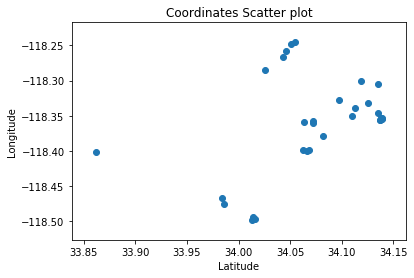

In [38]:
import matplotlib.pyplot as plt
plt.scatter(nearby_venues['lat'],nearby_venues['lng'])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Coordinates Scatter plot')
plt.show()

To get a better understanding, we can create a map of Los Angeles and add the most popular venues as markers (with descriptive labels).

In [25]:
# create map of Los Angeles using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, cat in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['category']):
    label = folium.Popup(label+"\n Category: "+ cat)
    folium.Marker(
         [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

From the above map, we can infer that a majority of popular venues are located to *North-West of Los Angeles* mostly situated around **Hollywood**.

## K-Means Clustering

We use K-means algorithm to *cluster the venues*. K-Means algorithm is one of the most common clustering methods in unsupervised learning.

We will run K-Means to cluster the venues into 5 clusters as we will plan on a **5 day trip** to Los Angeles.


In [43]:
from sklearn.cluster import KMeans # Importing KMeans

#set number of clusters to 5
kclusters = 5

# Creating an instance of KMeans to find k clusters
kmeans_1 = KMeans(n_clusters=kclusters)

# Using fit_predict to cluster the dataset
X = nearby_venues[['lng','lat']].values
predictions = kmeans_1.fit_predict(X)
predictions

array([2, 2, 1, 1, 4, 1, 2, 1, 2, 2, 0, 4, 4, 0, 4, 2, 0, 2, 2, 4, 4, 0,
       2, 2, 2, 4, 3, 1, 0, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the venues.

In [45]:
clustered = pd.concat([nearby_venues.reset_index(), 
                       pd.DataFrame({'Cluster':predictions})], 
                      axis=1)

In [46]:
clustered.drop('index', axis=1, inplace=True)

In [47]:
conditions = [
    clustered['Cluster'] == 0, 
    clustered['Cluster'] == 1,
    clustered['Cluster'] == 2,
    clustered['Cluster'] == 3,
    clustered['Cluster'] == 4]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
clustered['Vacation Day'] = np.select(conditions, days)

In [48]:
clustered.sort_values(by=['Cluster'])

,name,category,lat,lng,Cluster,Vacation Day
21,Whole Foods Market,Grocery Store,34.046101,-118.257732,0,Monday
10,STAPLES Center,Basketball Stadium,34.043085,-118.267191,0,Monday
13,Grand Central Market,Market,34.050675,-118.248741,0,Monday
28,Grand Park,Park,34.055034,-118.245179,0,Monday
16,USC Village,College Residence Hall,34.025655,-118.284652,0,Monday
27,Venice Canals,Canal,33.983440,-118.466314,1,Tuesday
2,Third Street Promenade,Shopping Plaza,34.015445,-118.496161,1,Tuesday
3,Venice Beach,Beach,33.986001,-118.475833,1,Tuesday
5,Santa Monica Place,Shopping Mall,34.013636,-118.493911,1,Tuesday
7,Santa Monica State Beach,State / Provincial Park,34.013090,-118.498265,1,Tuesday


Finally, let's visualize the resulting clusters

In [49]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered['lat'], clustered['lng'], clustered['name'], clustered['Cluster']):
    label = folium.Popup(str(poi) + '\n Day ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Looking good. We can now get an idea of the most popular places to visit in Los Angeles on each of the days.

## Results <a name="results"></a>

Let's create a travel itinerary from the cluster output.

In [86]:
#Get the name, category and vacation day from the clustered output dataframe
travel_itinerary = clustered[['name','category','Cluster','Vacation Day']]

#Change column names
travel_itinerary.columns = ['Place of Interest/Venue','Category','Day','Vacation Day']

#Add one to each day value as index begins from 0
travel_itinerary.loc[:,'Day'] = travel_itinerary['Day'] + 1

#Sort venues by day and category
travel_itinerary.sort_values(by=['Day','Category'],inplace=True)

#Reset index
travel_itinerary.reset_index(drop=True,inplace=True)

#Display the travel itinerary
travel_itinerary

/Users/anandhasudhan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Place of Interest/Venue,Category,Day,Vacation Day
0,STAPLES Center,Basketball Stadium,1,Monday
1,USC Village,College Residence Hall,1,Monday
2,Whole Foods Market,Grocery Store,1,Monday
3,Grand Central Market,Market,1,Monday
4,Grand Park,Park,1,Monday
5,Venice Beach,Beach,2,Tuesday
6,Venice Canals,Canal,2,Tuesday
7,Santa Monica Place,Shopping Mall,2,Tuesday
8,Third Street Promenade,Shopping Plaza,2,Tuesday
9,Santa Monica State Beach,State / Provincial Park,2,Tuesday


We can now use this travel itinerary as a starting point to plan our vacation accordingly. 

In [88]:
map_clusters

#### Day 1 (Monday)

In [87]:
travel_itinerary[travel_itinerary['Day'] == 1]

,Place of Interest/Venue,Category,Day,Vacation Day
0,STAPLES Center,Basketball Stadium,1,Monday
1,USC Village,College Residence Hall,1,Monday
2,Whole Foods Market,Grocery Store,1,Monday
3,Grand Central Market,Market,1,Monday
4,Grand Park,Park,1,Monday


We visit Los Angeles city and popular venues in the city.

#### Day 2 (Tuesday)

In [89]:
travel_itinerary[travel_itinerary['Day'] == 2]

,Place of Interest/Venue,Category,Day,Vacation Day
5,Venice Beach,Beach,2,Tuesday
6,Venice Canals,Canal,2,Tuesday
7,Santa Monica Place,Shopping Mall,2,Tuesday
8,Third Street Promenade,Shopping Plaza,2,Tuesday
9,Santa Monica State Beach,State / Provincial Park,2,Tuesday


On day 2, we visit the Venice Beach and Canals as they are close to each other. Then, proceed for shopping and finally have a relaxing evening at the Santa Monica State Beach.

#### Day 3 (Wednesday)

In [90]:
travel_itinerary[travel_itinerary['Day'] == 3]

,Place of Interest/Venue,Category,Day,Vacation Day
10,Universal Studios Hollywood Globe and Fountain,Fountain,3,Wednesday
11,ArcLight Cinemas,Multiplex,3,Wednesday
12,The Hollywood Bowl,Music Venue,3,Wednesday
13,Griffith Observatory,Observatory,3,Wednesday
14,Griffith Park,Park,3,Wednesday
15,Lake Hollywood Park,Park,3,Wednesday
16,Universal Studios Hollywood,Theme Park,3,Wednesday
17,The Wizarding World of Harry Potter,Theme Park Ride / Attraction,3,Wednesday
18,Studio Tour,Theme Park Ride / Attraction,3,Wednesday
19,Norman Bates' Trunk,Theme Park Ride / Attraction,3,Wednesday


Wednesday can be reserved for a visit to the famous Universal Studios Hollywood and attractions nearby. A solid day can be spent at the Universal studios.

#### Day 4 (Thursday)

In [91]:
travel_itinerary[travel_itinerary['Day'] == 4]

,Place of Interest/Venue,Category,Day,Vacation Day
22,Hermosa Beach - The Strand,Beach,4,Thursday


On Day 4, we can travel to the Hermosa Beach and spend some time there. It certainly involves some travel getting to the Hermosa Beach. Hence, you might end up spending the whole day at the beach.

#### Day 5 (Friday)

In [93]:
travel_itinerary[travel_itinerary['Day'] == 5]

,Place of Interest/Venue,Category,Day,Vacation Day
23,Los Angeles County Museum of Art (LACMA),Art Museum,5,Friday
24,Urth Caffé,Café,5,Friday
25,Urth Caffé,Café,5,Friday
26,The Original Farmers Market,Farmers Market,5,Friday
27,Beverly Wilshire Hotel (A Four Seasons Hotel) ...,Hotel,5,Friday
28,Montage Beverly Hills,Hotel,5,Friday
29,The Grove,Shopping Mall,5,Friday


Finally, on day 5, we can choose to visit the Los Angeles County Museum of Art (LACMA), then back to shopping at The Grove and visit hotels and cafe as time allows. 

## Discussion <a name="discussion"></a>

The travel itinerary would help new travellers plan their vacation well by maximizing their time spent in enjoyment.

As I mentioned before, we clustered only the 30 most popular venues in Los Angeles. If we were to spend a lot of time (weeks/months) in Los Angeles, we would certainly need more venues for clustering (to visit all popular venues). Currently, the foursquare API only returns 30 most popular venues in Los Angeles. However, we could go for a paid plan and choose to get any number of popular venues. 

I used the **K-means algorithm** as part of this clustering study. I set the k-value to 5 to generate 5 clusters **(for a 5-day trip itinerary)**. However, only 30 venues were used. For more detailed and accurate guidance, the data set can be expanded and the details of the venues can also be drilled.

I ended the study by visualizing the data and clustering information on the Los Angeles map.

## Conclusion <a name="conclusion"></a>

In this project, I described how I generated a travel plan for a trip to Los Angeles. With Foursquare location data, and k-means, I discovered the most popular venues I could visit on each day during the trip. 

According to clustering, I should spend 
 * one day at the Los Angeles city, 
 * one day visiting Los Angeles County Museum of Art (LACMA),
 * one day at the Universal Studios Hollywood, 
 * one day at the Hermosa Beach and 
 * one day at the Venice beach. 
 
The above plan can be used as a starting point to plan my travel.

Final decision on **venues to visit** will be made based on *available time* and *personal interest* in every recommended cluster, taking into consideration additional factors like attractiveness of each location (proximity to park or water), crowd level, and financial resources.